<a href="https://colab.research.google.com/github/Tariquzzaman-faisal/VITD/blob/main/lstm_cbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting to drive

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [134]:
!pip install tensorflow

In [135]:
# !pip install fasttext

In [136]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input, Flatten, MaxPooling1D, SpatialDropout1D, Activation

from keras.callbacks import EarlyStopping

from numpy import array
from sklearn.metrics import classification_report

import gensim
from gensim import models
from gensim.models import Word2Vec
# import fasttext.util
import pandas as pd
import numpy as np

# Loading Model

In [137]:
# fasttext_model = fasttext.load_model("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/fasttext/model_bn_300.bin")

# Load Dataset

In [138]:
train_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/train.csv")
val_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/dev.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/dataset/task datasets/original/test.csv")

In [139]:
print(f'train: {train_dataset.shape}\nval: {val_dataset.shape}\ntest: {test_dataset.shape}')

train: (2700, 2)
val: (1330, 2)
test: (2016, 2)


# Oversampling

In [140]:
train_dataset['label'].value_counts()

0    1389
1     922
2     389
Name: label, dtype: int64

In [141]:
# # Find the maximum class frequency
# max_class_frequency = train_dataset['label'].value_counts().max()

# # Group the dataset by labels
# grouped = train_dataset.groupby('label')

# resampled_data = []
# for label, group in grouped:
#     if len(group) < max_class_frequency:
#         oversampled_group = group.sample(max_class_frequency, replace=True, random_state=42)
#         resampled_data.append(oversampled_group)
#     else:
#         resampled_data.append(group)

# # Concatenate the resampled groups to create the balanced dataset
# balanced_dataset = pd.concat(resampled_data)

# # Shuffle the dataset to ensure randomness
# balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [142]:
# grouped.head()

In [143]:
# balanced_dataset.shape

In [144]:
# balanced_dataset['label'].value_counts()

In [145]:
# train_dataset = balanced_dataset
# train_dataset['label'].value_counts()

In [146]:
train_x = train_dataset['text']
train_y = train_dataset['label']

val_x = val_dataset['text']
val_y = val_dataset['label']

test_x = test_dataset['text']
test_y = test_dataset['label']

# Embedding Setup

In [147]:
tokenizer=Tokenizer(oov_token = "<OOV>", split=' ') # Splitting text based on whitespace and adding "Out of vocabulary"
tokenizer.fit_on_texts(train_x) # Using the tokenizer on out train dataset to tokenize the train dataset
train_encoded=tokenizer.texts_to_sequences(train_x)

In [148]:
train_padded= pad_sequences(train_encoded, padding='post',  maxlen=256)

In [149]:
# padding df_validation
val_encoded=tokenizer.texts_to_sequences(val_x)
val_padded= pad_sequences(val_encoded, padding='post', maxlen=train_padded.shape[1])

In [150]:
# padding df_validation
test_encoded=tokenizer.texts_to_sequences(test_x)
test_padded= pad_sequences(test_encoded, padding='post', maxlen=train_padded.shape[1])

In [151]:
# # function that takes word vector as input and returned an embedding layer
# def embedding_creation(EMBEDDING_DIM, word_vectors):
#   vocabulary_size=len(tokenizer.word_index)+1
#   word_index=tokenizer.word_index
#   embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

#   for word, i in word_index.items():
#     try:
#       embedding_vector=word_vectors[word] # taking the word vector of all the words in the index
#       embedding_matrix[i]=embedding_vector # inserting the vector of the word to the embeddings matrix,  index wise
#     except KeyError:
#       embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
#       """
#       The strategy of generating random vectors for missing words (KeyError)
#       in the embedding matrix is useful because it provides a way to
#       include out-of-vocabulary words in the representation,
#         prevents loss of information, helps with stable training, and
#         ensures a complete embedding matrix for neural network models.
#       """
#   embedding_layer=Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)

#   return embedding_layer

In [152]:
# EMBEDDING_DIM = 300
# wv = fasttext_model
# IFT = embedding_creation(EMBEDDING_DIM, wv)
# # gets the embedding layer from the word vectors using EMBEDDING_DIM as dim size

In [153]:
# max_length = train_padded.shape[1]
# vocabulary_size = len(tokenizer.word_index) + 1
# # creating a randomly initialized embedding layer (RE)
# RE = Embedding(vocabulary_size, EMBEDDING_DIM,input_length = max_length, trainable=True)

# Early Stopping

In [154]:
earlystop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [155]:
# emb_X_name_collection = [ [IFT, 'IFT']]

# Model Configuration Orignal

In [156]:
!pip install keras

In [157]:
from tensorflow.keras.layers import Layer, Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

In [158]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()


In [159]:
# num_classes = 3
# # Loop through each embedding layer and create models with attention
# for emb_X_name in emb_X_name_collection:
#     model = Sequential([
#         emb_X_name[0],
#         Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)),
#         attention(),
#         Dense(16, activation='relu'),
#         Dense(num_classes, activation='softmax'),  # Use softmax for multi-class classification
#     ],
#     name="Sentiment_Model")
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [160]:
# from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam

# num_classes = 3
# learning_rate = 0.001  # Adjust the learning rate as needed
# EMB_DIM = 300
# max_len = train_padded.shape[1]
# vocabulary_size=len(tokenizer.word_index)+1
# # model = Sequential([
# #     Embedding(input_dim = vocabulary_size, output_dim = EMB_DIM, input_length = max_len),
# #     LSTM(150, dropout=0.3, return_sequences=True),
# #     Dense(16, activation = 'relu'),
# #     Dense(num_classes, activation='softmax')
# # ], name="BiLSTM_no_FT")

# # optimizer = Adam(learning_rate=learning_rate)  # Set the learning rate for the optimizer

# # model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [161]:
# model = Sequential()
# model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, input_length=max_len))
# model.add(LSTM(150, dropout=0.3, return_sequences=True))
# # model.add(attention()),
# model.add(GlobalMaxPool1D())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(3, activation='softmax'))  # Assuming 3 classes (0, 1, 2)

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [162]:
from tensorflow.keras.layers import Embedding, Lambda, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K  # Import Keras backend for the Lambda layer
import numpy as np

# Assuming you have already tokenized and padded your text data
# X_train_padded and y_train should contain the padded sequences and labels, respectively
# You also need the tokenizer and vocab_size as defined in your original code

# Hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
window_size = 2  # Context window size
lstm_units = 150
dense_units = 32
num_classes = 3  # Assuming 3 classes (0, 1, 2)
learning_rate = 0.001  # Learning rate
max_len = train_padded.shape[1]

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# Define a Lambda layer to average the word embeddings within the context window
# model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embedding_dim,)))
model.add(GlobalMaxPool1D())
model.add(Dense(dense_units, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Add the learning rate to the Adam optimizer
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training

In [163]:
history = model.fit(train_padded, train_y, epochs=100, batch_size=32, validation_data=(val_padded, val_y), callbacks=[earlystop_callback])

Epoch 1/100
85/85 [==============================] - 20s 225ms/step - loss: 0.9851 - accuracy: 0.5048 - val_loss: 0.9372 - val_accuracy: 0.5541
Epoch 2/100
85/85 [==============================] - 18s 209ms/step - loss: 0.8261 - accuracy: 0.6478 - val_loss: 0.7906 - val_accuracy: 0.6571
Epoch 3/100
85/85 [==============================] - 5s 61ms/step - loss: 0.5435 - accuracy: 0.8004 - val_loss: 0.6991 - val_accuracy: 0.7060
Epoch 4/100
85/85 [==============================] - 4s 50ms/step - loss: 0.2682 - accuracy: 0.9263 - val_loss: 0.7106 - val_accuracy: 0.7008
Epoch 5/100
85/85 [==============================] - 4s 47ms/step - loss: 0.1129 - accuracy: 0.9774 - val_loss: 0.7119 - val_accuracy: 0.7135
Epoch 6/100
85/85 [==============================] - 2s 28ms/step - loss: 0.0467 - accuracy: 0.9937 - val_loss: 0.7485 - val_accuracy: 0.7098
Epoch 7/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0208 - accuracy: 0.9989 - val_loss: 0.7757 - val_accuracy: 0.7030
Ep

In [164]:
# history = model.fit(train_padded, train_y, epochs=100, batch_size=32, validation_data=(test_padded, test_y), callbacks=[earlystop_callback])

In [165]:
# model.save("/content/drive/MyDrive/Research/final-model")  # Save the model in an h5 format

In [166]:
prediction = model.predict(test_padded)

p = []
for i in range(len(prediction)):
    a = []
    for j in range(3):
        a.append(round(prediction[i][j]))
    p.append(a)


63/63 [==============================] - 0s 3ms/step


In [167]:
# prediction

In [168]:
# Determine the maximum column index for each row
max_indices = np.argmax(p, axis=1)

# Create a DataFrame with the max_indices
pred_labels = pd.DataFrame({'Value': max_indices})

In [169]:
# pred_labels

In [170]:
from sklearn.metrics import classification_report

target_names = ['neutral', 'passive', 'direct']
r = classification_report(test_y, pred_labels, output_dict=True)

In [171]:
# r

In [172]:
df = pd.DataFrame(r)

# Transpose the DataFrame
df = df.transpose()

print(df)

              precision    recall  f1-score      support
0              0.649721  0.956204  0.773717  1096.000000
1              0.820225  0.406120  0.543256   719.000000
2              0.936170  0.218905  0.354839   201.000000
accuracy       0.686508  0.686508  0.686508     0.686508
macro avg      0.802039  0.527076  0.557271  2016.000000
weighted avg   0.739090  0.686508  0.649761  2016.000000


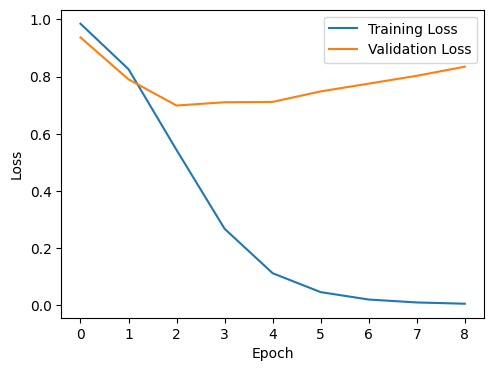

In [173]:
import matplotlib.pyplot as plt
# Plot the training history
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


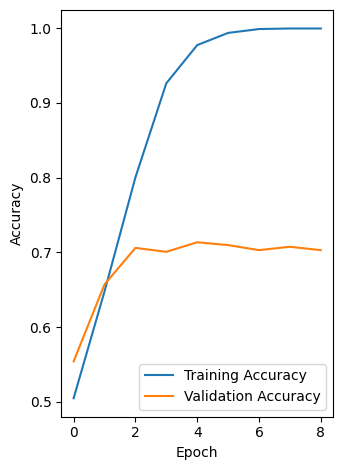

In [174]:
# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [175]:
# model.save("/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/notebooks/Tariq/final/nafi/LSTMcbow.h5")  # Save the model in an h5 format